# Topic analysis (LDA)

In [1]:
from pprint import pprint
import json
import pandas as pd  
import numpy as np
import re

Data uitlezen. Eerst getest met een dataset van 1000 tweets. Daarna mini_twitter_geotagged_clean. Gebruik de hele dataset later.

In [2]:
%%time
# Verander in de regel hieronder de locatie van de data
tweets = pd.read_json("mini_twitter_geotagged_clean.json", orient='records', lines=True)

Wall time: 14.2 s


In [3]:
tweets['CleanText'] = tweets['CleanText'].replace('\n','')
tweets['CleanText'] = tweets['CleanText'].replace('\t','')
tweets['CleanText'] = tweets['CleanText'].replace('amp','')
tweets['CleanText'] = tweets['CleanText'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

We willen splitten tussen hillary en trump tweets. We doen dus uiteindelijk LDA twee keer.

In [13]:
#iets zoals dit. Selecteer 1 van de twee
#tweets.loc[tweets['sentiment'] == "hillary"]
#tweets.loc[tweets['sentiment'] == "trump"]

In [14]:
tweets.head()

,CleanText,contributors,coordinates,created_at,entities,extended_entities,favorite_count,favorited,filter_level,geo,...,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,source,text,timestamp_ms,truncated,user
0,COLLUSION TOGETHER httpstco5GMNZq40V3,NaN,None,2016-08-12 10:04:02,"{'hashtags': [{'text': 'NOJUSTICE', 'indices':...",None,0,False,low,None,...,None,NaN,NaN,0,False,"<a href=""http://twitter.com/download/android"" ...",@BarackObama \n@FBI\n@LORETTALYNCH \nALL IN CO...,2016-08-12 10:04:02.194,False,"{'id': 82496193, 'id_str': '82496193', 'name':..."
1,will year things should have done eight,NaN,None,2016-08-12 10:04:21,"{'hashtags': [], 'urls': [], 'user_mentions': ...",None,0,False,low,None,...,None,NaN,NaN,0,False,"<a href=""http://twitter.com/download/iphone"" r...",@HillaryClinton he will do in one year all the...,2016-08-12 10:04:21.125,False,"{'id': 44032624, 'id_str': '44032624', 'name':..."
2,clear deliberately throwing this racein 2007 k...,NaN,None,2016-08-12 10:04:30,"{'hashtags': [{'text': 'CNN', 'indices': [0, 4...",None,0,False,low,None,...,None,NaN,NaN,0,False,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",#CNN #newday clear #Trump deliberately throwin...,2016-08-12 10:04:30.035,False,"{'id': 769208504, 'id_str': '769208504', 'name..."
3,wouldnt recognize came from your mouth they co...,NaN,None,2016-08-12 10:04:46,"{'hashtags': [{'text': 'NeverTrump', 'indices'...",None,0,False,low,None,...,{'created_at': 'Fri Aug 12 04:10:25 +0000 2016...,7.639507e+17,7.639507e+17,0,False,"<a href=""http://twitter.com/download/iphone"" r...","@realDonaldTrump, you wouldn't recognize a lie...",2016-08-12 10:04:46.265,False,"{'id': 41043316, 'id_str': '41043316', 'name':..."
4,know suing someone Thats most beautiful thing ...,NaN,None,2016-08-12 10:04:48,"{'hashtags': [], 'urls': [], 'user_mentions': ...",None,0,False,low,None,...,None,NaN,NaN,0,False,"<a href=""http://twitter.com/download/iphone"" r...","""Kid, you know, suing someone? Thats the most ...",2016-08-12 10:04:48.229,False,"{'id': 762090248159371264, 'id_str': '76209024..."


we maken een array aan met alle clean tekst uit de tweets

In [15]:
doc_complete = tweets['CleanText'].values

We moeten nog lemmatizen en stopwoorden verwijderen

In [16]:
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

# Create a set of stopwords
stop = set(stopwords.words('english'))

# Create a set of punctuation words 
exclude = set(string.punctuation) 

# This is the function makeing the lemmatization
lemma = WordNetLemmatizer()

# In this function we perform the entire cleaning
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

# This is the clean corpus.
doc_clean = [clean(doc).split() for doc in doc_complete]

Maak een dictionary aan voor alle woorden

In [17]:
# Importing Gensim
import gensim
from gensim import corpora

# Creating the term dictionary of our courpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(doc_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

LDA toepassen
pas de num_topics aan voor het aantal topics: getest op een paar topics tot 100. Meer geeft een duidelijkere groepering, moeten nog kijken wat we kunnen gebruiken voor het verslag.
Hoe hoger het aantal passes hoe beter het resultaat. Passes getest op 50. Dat duurt ong 15 minuten op mijn laptop.

In [18]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=20, id2word = dictionary, passes=5)

nu kunnen we de topics printen
zorg dat num_topics hetzelfde is als hierboven.
num_words laat het aantal woorden zien per topic. 

In [19]:
topics = ldamodel.print_topics(num_topics=20, num_words=5)

i=0
for topic in topics:
    print ("Topic",i ,"->", topic)
    i+=1


Topic 0 -> (0, '0.083*"right" + 0.033*"still" + 0.024*"woman" + 0.023*"exactly" + 0.020*"question"')
Topic 1 -> (1, '0.037*"campaign" + 0.026*"money" + 0.025*"talk" + 0.024*"maybe" + 0.024*"medium"')
Topic 2 -> (2, '0.042*"real" + 0.030*"nothing" + 0.025*"hope" + 0.024*"report" + 0.020*"getting"')
Topic 3 -> (3, '0.096*"like" + 0.037*"look" + 0.034*"well" + 0.021*"would" + 0.018*"freedom"')
Topic 4 -> (4, '0.074*"dont" + 0.048*"think" + 0.041*"youre" + 0.040*"know" + 0.024*"word"')
Topic 5 -> (5, '0.047*"today" + 0.042*"2016" + 0.034*"pressure" + 0.033*"fine" + 0.033*"forecast"')
Topic 6 -> (6, '0.102*"people" + 0.053*"time" + 0.044*"medium" + 0.034*"thing" + 0.033*"many"')
Topic 7 -> (7, '0.084*"vote" + 0.038*"trump" + 0.037*"keep" + 0.033*"press" + 0.027*"need"')
Topic 8 -> (8, '0.049*"clinton" + 0.048*"make" + 0.045*"america" + 0.040*"hillary" + 0.036*"great"')
Topic 9 -> (9, '0.027*"message" + 0.025*"hell" + 0.020*"free" + 0.019*"let" + 0.018*"call"')
Topic 10 -> (10, '0.045*"retur

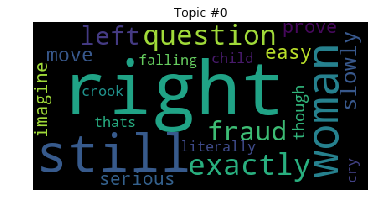

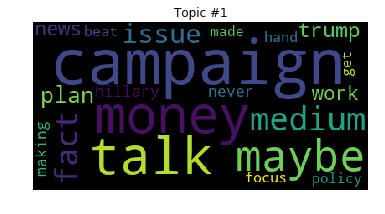

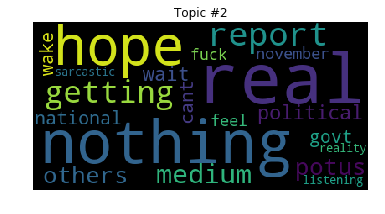

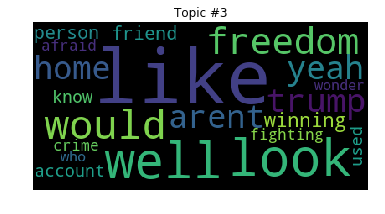

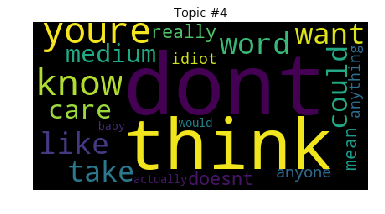

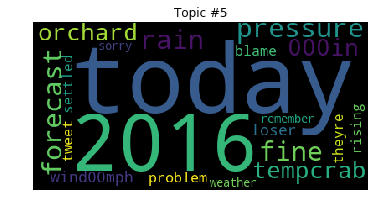

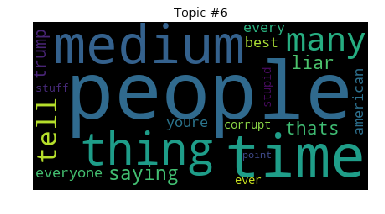

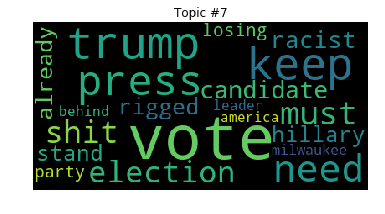

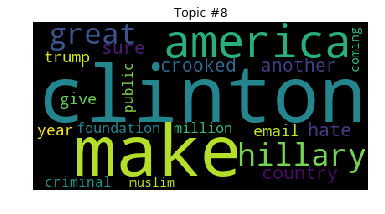

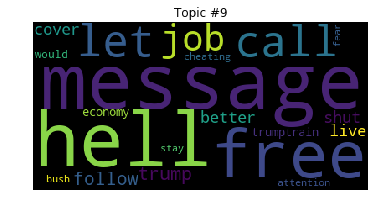

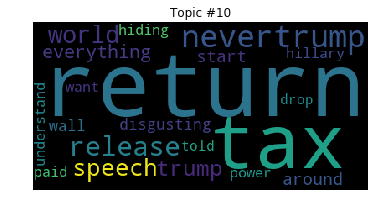

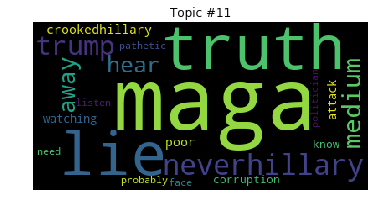

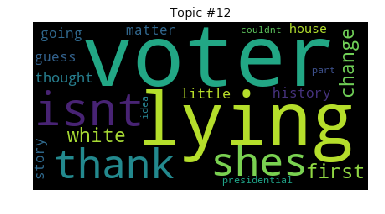

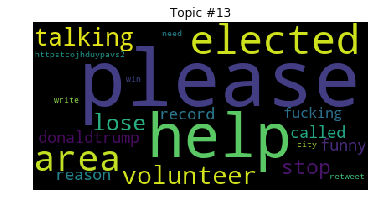

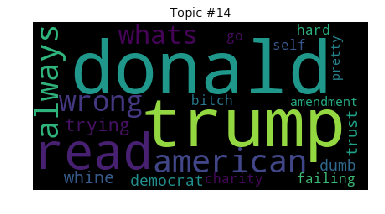

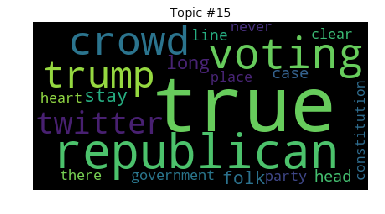

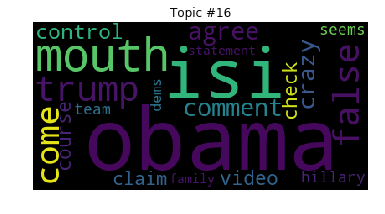

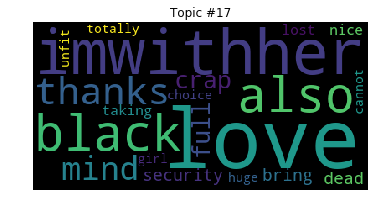

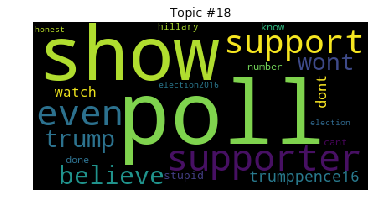

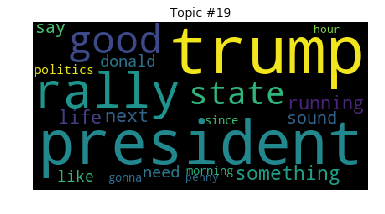

In [20]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
for t in range(ldamodel.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(ldamodel.show_topic(t, 20))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()